In [188]:
import geopandas as gpd
import pandas as pd
from glob import glob
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
wd = '/datadrive/csv'

In [7]:
scenario_list = ['rcp45', 'rcp85']
s = scenario_list[0]
#df = pd.read_csv(glob(f'{wd}/*{s}*')[0], chunksize=1e5)
df = dd.read_csv(glob(f'{wd}/*{s}*')[0])
df['img_date'] = df['img_date'].astype('datetime64')

In [228]:
def ag_func(df):
    d = {}
    d['tasmax'] = df['tasmax'].mean()
    d['tasmin'] = df['tasmin'].mean()
    d['pr'] = df['pr'].sum()
    return pd.Series(d)

def aggregate_by_model(df, model_name, year_range=(2006,2100)):
    query = df.xs(model_name, level='model')
    query = query[(query.index.year >= year_range[0]) & (query.index.year <= year_range[1])]
    q_agg = query.groupby([query.index.year, \
                           query.index.month]).apply(ag_func)
    q_agg.index.names = ['year', 'month']
    columns = [(f'{model_name}',n) for n in q_agg.columns.values]
    q_agg.columns = pd.MultiIndex.from_tuples(columns)
    return q_agg

def create_gcm_summary(filename):
    #df = pd.read_csv(glob(f'{wd}/*{s}*')[0], chunksize=1e5)
    df = dd.read_csv(filename)
    df['img_date'] = df['img_date'].astype('datetime64')
    df['tasmin'] = df['tasmin'] - 273.15
    df['tasmax'] = df['tasmax'] - 273.15
    df['pr'] = df['pr'] * 86400
    model_list = np.unique(np.array([v[1] for v in groups.index.values]))
    df_summary = pd.concat([aggregate_by_model(groups, model) for model in model_list],\
                       axis=1).dropna()
    df_summary.columns.names = ['model', 'climate']
    return df_summary

In [8]:
df['tasmin'] = df['tasmin'] - 273.15
df['tasmax'] = df['tasmax'] - 273.15
df['pr'] = df['pr'] * 86400

In [9]:
#take the mean of all the points 
groups = df.groupby(['img_date','model'])['tasmax','tasmin','pr'].mean().compute()

/usr/local/lib/python3.6/dist-packages/dask/dataframe/groupby.py:1729: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  g._meta = g._meta[key]


In [10]:
#get the list of model names
model_list = np.unique(np.array([v[1] for v in groups.index.values]))

In [158]:
#execute summary
df_summary = pd.concat([aggregate_by_model(groups, model) for model in model_list],\
                       axis=1).dropna()
df_summary.columns.names = ['model', 'climate']

In [227]:
df_summary.to_csv(f'{wd}/GDDP_processed.csv')

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

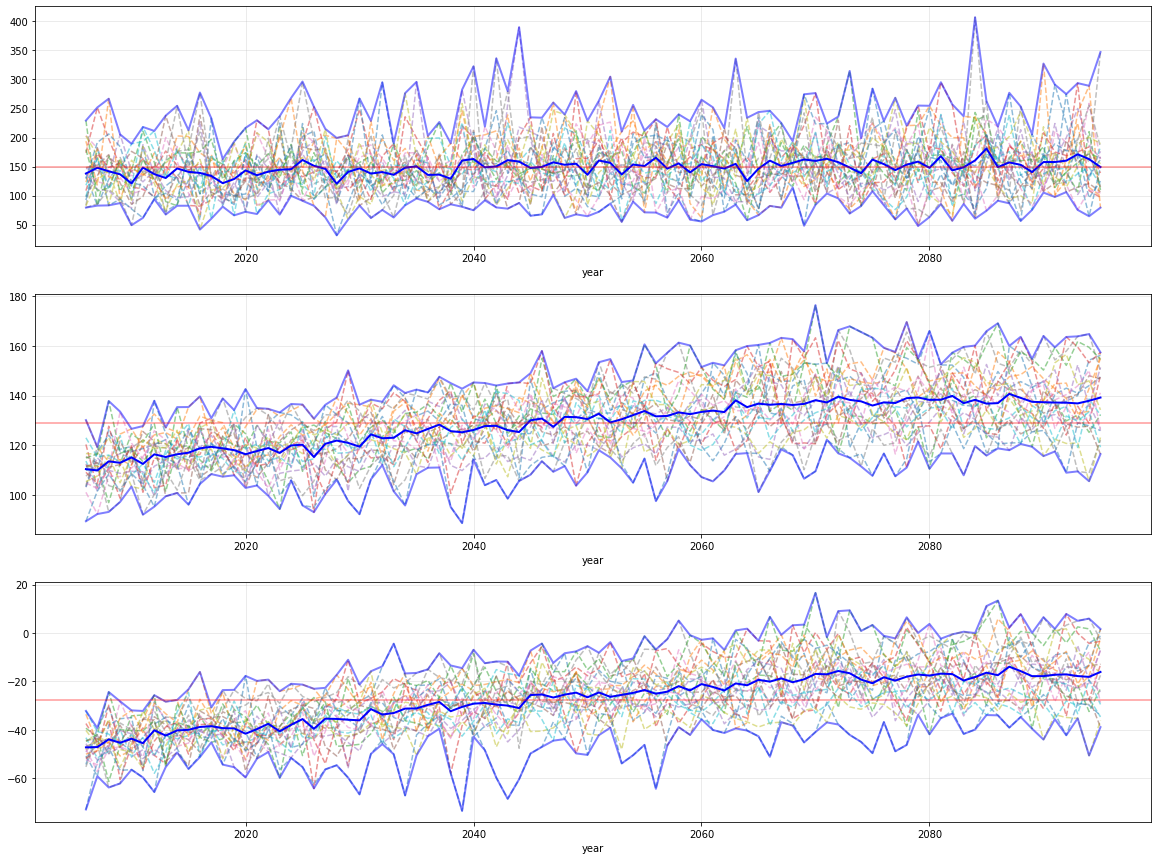

In [225]:
climate_vars = df_summary.columns.levels[-1].values
f, ax = plt.subplots(len(climate_vars),1,figsize=(20,15))
for i, var in enumerate(climate_vars):
    summary = df_summary.groupby('year').agg('sum').xs(var, level='climate', axis=1)
    summary.plot(ax=ax[i], ls='--',alpha=0.5, legend=False)
    summary.agg('mean', axis=1).plot(ax=ax[i], lw=2, color='blue')
    summary.agg('max', axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    summary.agg('min', axis=1).plot(ax=ax[i], lw=2, color='blue', alpha=0.5)
    ax[i].axhline(summary.agg('mean', axis=1).mean(), color='red', alpha=0.3, lw=2)
    ax[i].grid(alpha=0.3)

In [ ]:
#now apply the historic record of climate for the region


In [ ]:
#do a for loop within each model
#generate a new master list that is an aggregate by model
#plot these over time
#repeat for Rio-Mora